In [2]:
from variables import *

import os, sys
script_dir = os.getcwd()
module_path = script_dir
for _ in range(1):
    module_path = os.path.abspath(os.path.join(module_path, '../'))
    if module_path not in sys.path:
        sys.path.insert(0,module_path)
        
from src import decode_moddeling
import pandas as pd
from plotnine import *
import plotnine as p9

/Users/abambhaniya3/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# This will reload the imported modules (e.g. get_decode_model_characterstics) every time you execute the jupyter cells, so that you don't need to restart the notebook after updating the source codes.
%load_ext autoreload
%autoreload 2   

In [4]:
Model_list = Model_list[3:] + ['super_llm'] 
Model_names_in_plot = Model_names_in_plot[3:] + ['Super LLM - 10T'] 

In [5]:
data = []
for in_tokens in range(100*1024, 2024000, 10240):
    b,bb, out_tokens, thrpt = 1,4, 2000, 5
    time_per_token = 1/thrpt
    for model in Model_list:
        model_df, summary_table = decode_moddeling(model = model, batch_size = b, Bb = bb ,
                                input_tokens = in_tokens, output_tokens = out_tokens, model_profilling=True,
                                tensor_parallel = 1, pipeline_parallel = 1, bits='int8')
        total_params = (summary_table.loc[0,'Model Weights (MB)'] + summary_table.loc[0,'KV Cache (MB)'])
        unused_weight = summary_table.loc[0,'Unused Weights (MB)'] 
        Memory_BW_required = (( total_params - unused_weight) / 1e6 )/time_per_token  ## TB/s
        Compute_FLOPS_required = ((summary_table.loc[0,'MACs (MFLOP)'])/ 1e6)/time_per_token    ## TFLOPS/s
        data.append([model, in_tokens,Memory_BW_required, Compute_FLOPS_required]+list(summary_table.values[0]))
df = pd.DataFrame(data, columns=([ 'Model','Context Length', 'Req Memory BW(TB/s)', 'Req FLOPs (TFLOP/s)']+list(summary_table.columns)) )
df['Context Length'] = df['Context Length'] / 1e6
df['Total Memory Req (TB)'] = (df['Model Weights (MB)'] + df['KV Cache (MB)'])/2**20


/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 162.0 GB, KV Cache:242.578125 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 1819.125 GB, KV Cache:283.0078125 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 8839.125 GB, KV Cache:363.8671875 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:113: UserWarning: All params would not fit on chip. System Memory Cap:40.0 GB , Weights : 162.0 GB, KV Cache:265.078125 
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_dec

/opt/homebrew/Caskroom/miniconda/base/envs/modesa_dev/lib/python3.12/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_color_brewer could not recognise parameter `n`
/opt/homebrew/Caskroom/miniconda/base/envs/modesa_dev/lib/python3.12/site-packages/plotnine/scales/scale_shape.py:89: PlotnineWarning: Using shapes for an ordinal variable is not advised.


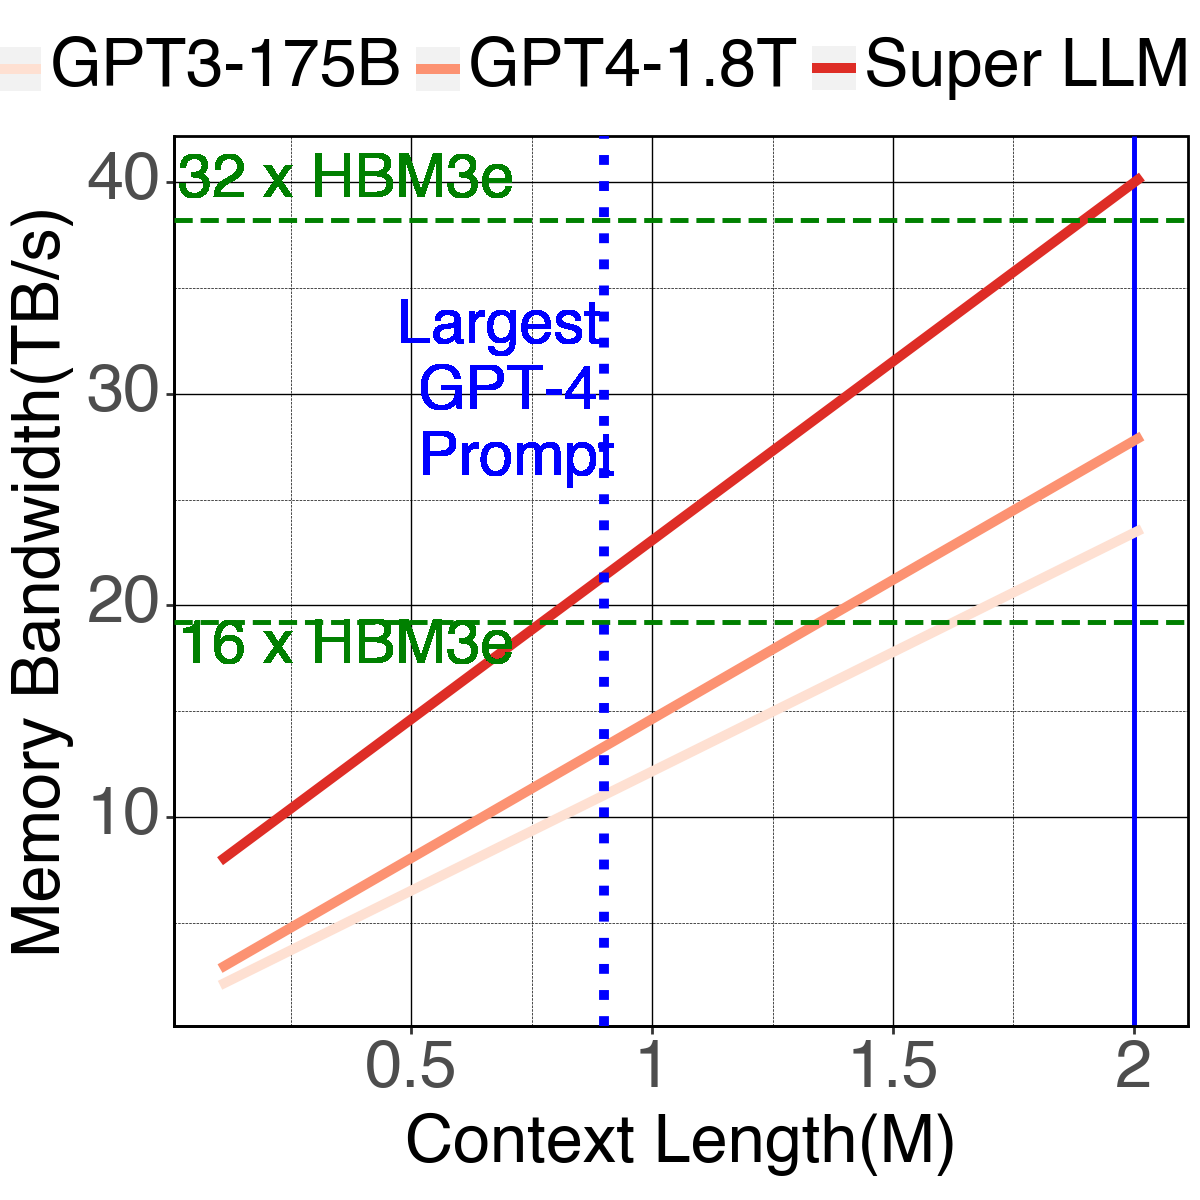

In [6]:
# Create the bar graph using plotnine
df['Model'] = df['Model'].astype(str)
plot_df = df.replace(Model_list ,Model_names_in_plot)
plot_df['Model'] = pd.Categorical(plot_df['Model'], categories=Model_names_in_plot, ordered=True)
plot = (
    
    p9.ggplot(plot_df, p9.aes(x='Context Length', y='Req Memory BW(TB/s)')) 
    + p9.geom_vline(xintercept=[2000*1000/ 1e6 ], linetype='solid', color='blue', size=1)  # Add horizontal lines
    + p9.geom_line(p9.aes(color='Model', shape='Model'), size =2) # line plot
    + p9.labs(y="Memory Bandwidth(TB/s)", x='Context Length(M)')
    + plot_theme
    + p9.theme(legend_position='top', legend_title=p9.element_blank())
    +  p9.geom_hline(yintercept=[ 19.2, 38.2 ], linetype='dashed', color='green', size=1)  # Add horizontal lines
    + p9.geom_text(p9.aes(y=18, x=400000/ 1e6), color='green', label='16 x HBM3e  ', size=22)  # Label  
    + p9.geom_text(p9.aes(y=40, x=400000/ 1e6), color='green', label='32 x HBM3e  ', size=22)  # Label  
    +  p9.geom_vline(xintercept=[900*1000/ 1e6 ], linetype='dotted', color='blue', size=2)  # Add horizontal lines

    + p9.geom_text(p9.aes(y=30, x=700000/ 1e6), color='blue', label='Largest \n GPT-4 \n Prompt', size=22)  # Label  

    +  p9.scale_color_brewer(palette='Reds', n=3)
    + p9.theme(figure_size=(6, 6))
)
# Show the plot
print(plot)


## Memory Size

/opt/homebrew/Caskroom/miniconda/base/envs/modesa_dev/lib/python3.12/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_color_brewer could not recognise parameter `n`


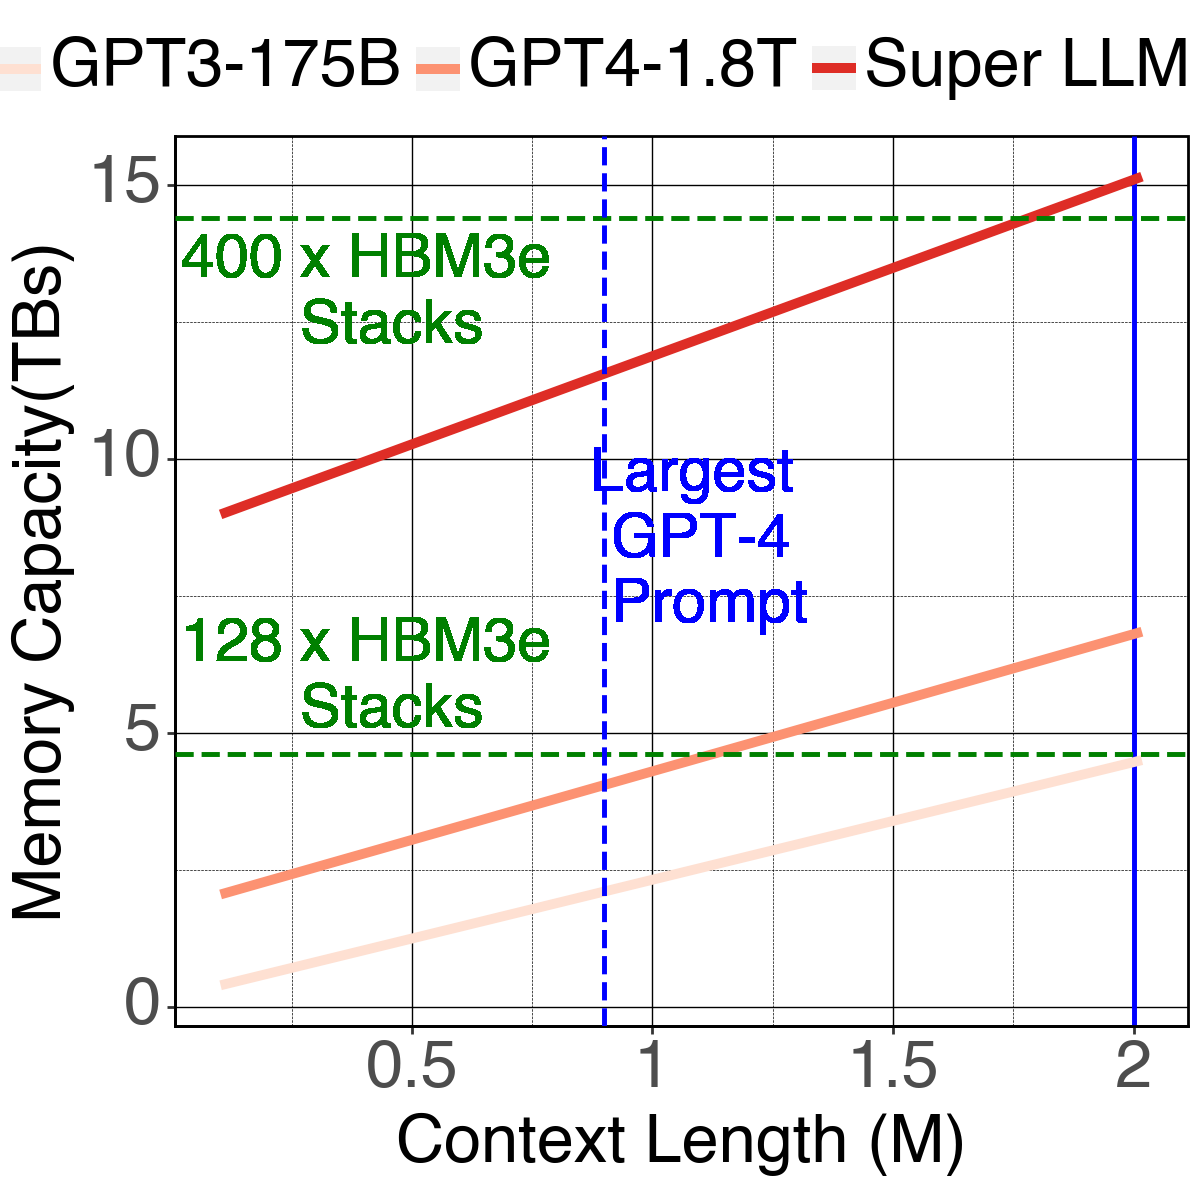

In [7]:
plot = (
    p9.ggplot(plot_df, p9.aes(x='Context Length', y='Total Memory Req (TB)'))
    + p9.geom_vline(xintercept=[2000*1000 /1e6], linetype='solid', color='blue', size=1)  # Add horizontal lines
    + p9.geom_line(p9.aes(color='Model'), size =2) # line plot 
    + p9.labs(x='Context Length (M)', y="Memory Capacity(TBs)")

    + plot_theme
    + p9.theme(legend_position='top', legend_title=p9.element_blank())

    +  p9.geom_hline(yintercept=[ 4.608 , 14.4 ], linetype='dashed', color='green', size=1)  # Add horizontal lines
    + p9.geom_text(p9.aes(y=6, x=440000 /1e6), color='green', label='128 x HBM3e  \n Stacks', size=22)  # Label  
    + p9.geom_text(p9.aes(y=13, x=440000 /1e6), color='green', label='400 x HBM3e  \n Stacks', size=22)  # Label  

    +  p9.geom_vline(xintercept=[900*1000  /1e6], linetype='dashed', color='blue', size=1)  # Add horizontal lines
    + p9.geom_text(p9.aes( x=1100000 /1e6, y=8.5,), color='blue', label='Largest \n GPT-4 \n Prompt', size=22)  # Label  
    +  p9.scale_color_brewer(palette='Reds', n=3)
    + p9.theme(figure_size=(6, 6))
)

# Show the plot
print(plot)
